In [57]:
## Imports
## System imports
import os
import sys

## Add root directory to path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../")))

## LangChain
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver
from langchain_community.utilities import SQLDatabase
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langgraph.prebuilt import create_react_agent, ToolNode, tools_condition
from langchain import hub
from langchain_core.tools import tool

## Python packages
import pandas as pd
from dotenv import load_dotenv
from datetime import datetime
from pprint import pprint
from typing import Annotated
from typing_extensions import TypedDict
from IPython.display import Image, display
from scipy.stats import pearsonr

## Self-defined modules
from utils import calculations, prompts

In [10]:
load_dotenv()
assert os.environ["LANGCHAIN_API_KEY"], "Please set the LANGCHAIN_API_KEY environment variable"
assert os.environ["GROQ_API_KEY"], "Please set the GROQ_API_KEY environment variable"
assert os.environ["OPENAI_API_KEY"], "Please set the OPENAI_API_KEY environment variable"

In [18]:
## Creating graph

class State(TypedDict):
    ## Messages have the type "list"
    ## The add_mesasges function in the annotation defines how this state key should be updated
    ## ie. it appends messages to the list, rather than overwriting it
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

## Add LLM node to graph
openai_llm = ChatOpenAI(model="gpt-4o-mini", api_key=os.environ["OPENAI_API_KEY"])

def generator(state: State):
    return {"messages": [openai_llm.invoke(state["messages"])]}

graph_builder.add_node("generator", generator) ## Node name, function to be called

## Add edges
graph_builder.add_edge(START, "generator")
graph_builder.add_edge("generator", END)

graph = graph_builder.compile()

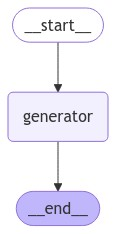

In [19]:
## Visualize graph
def draw_graph(graph):
    try:
        display(Image(graph.get_graph().draw_mermaid_png()))
    except:
        print("Error displaying graph")

draw_graph(graph)

In [ ]:
## Run the graph
def stream_graph_updates(graph, user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("LLM:", value["messages"][-1].content)

example_input = "What is the best place to visit for nature lovers?"

pprint(stream_graph_updates(graph, example_input))

In [ ]:
## Adding memory
memory = MemorySaver()
graph_with_memory = graph_builder.compile(checkpointer=memory)

## Run the graph
config_1 = {"configurable": {"thread_id": "1"}}

def stream_graph_memory(graph, user_input: str, config):
    events = graph.stream({"messages": [("user", user_input)]}, config=config, stream_mode="values")
    for event in events:
        event["messages"][-1].pretty_print()

stream_graph_memory(graph_with_memory, "I love going on nature walks", config_1)
stream_graph_memory(graph_with_memory, "Where do you recommend I visit?", config_1)

In [ ]:
## Use another thread
config_2 = {"configurable": {"thread_id": "2"}}

stream_graph_memory(graph_with_memory, "I love eating Japanese food", config_2)
stream_graph_memory(graph_with_memory, "Where do you recommend I visit?", config_2)

In [8]:
## Check memory
snapshot = graph_with_memory.get_state(config_1)
print("Thread 1: ", snapshot)

snapshot = graph_with_memory.get_state(config_2)
print("Thread 2: ", snapshot)

Thread 1:  StateSnapshot(values={'messages': [HumanMessage(content='I love going on nature walks', additional_kwargs={}, response_metadata={}, id='6812eaea-bf78-4c79-873f-73effbcc8ff9'), AIMessage(content="and immersing myself in the beauty of the outdoors. There's something so calming and rejuvenating about being surrounded by trees, plants, and wildlife. I enjoy the fresh air, the sounds of birds chirping, and the feeling of being connected to the earth. Nature walks are a great way for me to clear my mind, de-stress, and appreciate the little wonders of the natural world. I always feel more energized and at peace after spending time outdoors, and I look forward to my next nature walk adventure.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 106, 'prompt_tokens': 13, 'total_tokens': 119, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'mode

Integrating with SQL agent

In [20]:
## Set up
DATA_DIR = "../../../data/raw"
sqlite_db_path = DATA_DIR + "/orders.db"

db = SQLDatabase.from_uri(f"sqlite:///{sqlite_db_path}")
print(db.get_usable_table_names())

sql_toolkit = SQLDatabaseToolkit(db=db, llm=openai_llm)
sql_tools = sql_toolkit.get_tools()
pprint(sql_tools)

['orders']
[QuerySQLDataBaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x0000019B7FCAEA90>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x0000019B7FCAEA90>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x0000019B7FCAEA90>),
 QuerySQLCheckerTool(description='Use th

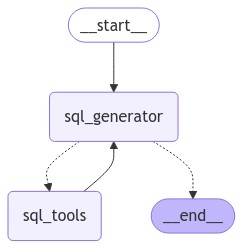

In [39]:
## Build graph with SQL tools
graph_builder = StateGraph(State)

## Initialize LLM with SQL tools
openai_llm = ChatOpenAI(model="gpt-4o-mini", api_key=os.environ["OPENAI_API_KEY"])
llm_with_sql_tools = openai_llm.bind_tools(sql_tools)

## Node for SQL tools
def sql_generator(state: State):
    state_messages = state["messages"]

    # ## Add state modifier. Provides instructions to LLM
    # prompt_template = hub.pull("langchain-ai/sql-agent-system-prompt")
    # system_message = SystemMessage(prompt_template.format(dialect="SQLite", top_k=5))
    # state_messages = add_messages(system_message, state_messages)

    return {"messages": [llm_with_sql_tools.invoke(state_messages)]}

graph_builder.add_node("sql_generator", sql_generator)

sql_tool_node = ToolNode(tools=sql_tools)
graph_builder.add_node("sql_tools", sql_tool_node)

## Function to create custom tool conditions
## Returns "tools" if the chatbot asks to use a tool, and "END" if it is fine directly responding
def create_tools_condition(tool_name: str="tools"):
    def ret_function(state: State):
        if isinstance(state, list):
            ai_message = state[-1]
        elif messages := state.get("messages", []):
            ai_message = messages[-1]
        else:
            raise ValueError(f"No messages found in input state to tool_edge: {state}")
        if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
            return tool_name
        return END
    
    return ret_function

## If the message in sql_generator has tool calls, this edge routes it to the tools
sql_tools_condition = create_tools_condition("sql_tools")
graph_builder.add_conditional_edges("sql_generator", sql_tools_condition)

## Every time tool is called, return to generator to determine next step
graph_builder.add_edge("sql_tools", "sql_generator")
graph_builder.set_entry_point("sql_generator")
sql_graph = graph_builder.compile()
draw_graph(sql_graph)

In [30]:
llm_with_sql_tools.invoke("Which security code had the highest volume of orders?").tool_calls

[{'name': 'sql_db_list_tables',
  'args': {},
  'id': 'call_3D6g0IDxEktQ2lHdYAk5IuSw',
  'type': 'tool_call'}]

In [ ]:
## Trying it out
sql_prompt = "Which security code had the highest quantity of orders?"
# sql_prompt = [HumanMessage("Which security code had the highest volume of orders?")]
# prompt_template = hub.pull("langchain-ai/sql-agent-system-prompt")
# system_message = SystemMessage(prompt_template.format(dialect="SQLite", top_k=5))
# sql_prompt = add_messages(system_message, sql_prompt)
# pprint(sql_prompt)

# sql_graph.invoke({"messages": sql_prompt})

pprint(stream_graph_updates(sql_graph, sql_prompt))


Try with Python analysis tools

In [54]:
import pandas as pd
from scipy.stats import pearsonr, chi2_contingency

def analyze_csv(file_path: str, col1: str, col2: str) -> dict:
    # Load the CSV file into a DataFrame
    df = pd.read_csv(file_path)
    
    # Check if the columns exist in the DataFrame
    if col1 not in df.columns or col2 not in df.columns:
        raise ValueError(f"Columns {col1} and/or {col2} not found in the CSV file.")
    
    # Initialize the result dictionary
    result = {}
    
    # Summary statistics for col1
    result[f'{col1}_summary'] = df[col1].describe(include='all').to_dict()
    
    # Summary statistics for col2
    result[f'{col2}_summary'] = df[col2].describe(include='all').to_dict()
    
    # Determine if columns are categorical or continuous
    col1_is_categorical = df[col1].dtype == 'object' or df[col1].nunique() < 10
    col2_is_categorical = df[col2].dtype == 'object' or df[col2].nunique() < 10
    
    # Relationship between col1 and col2
    if col1_is_categorical and col2_is_categorical:
        # Both columns are categorical
        contingency_table = pd.crosstab(df[col1], df[col2])
        chi2, p, _, _ = chi2_contingency(contingency_table)
        result['relationship'] = {
            'type': 'categorical-categorical',
            'contingency_table': contingency_table.to_dict(),
            'chi2_statistic': chi2,
            'p_value': p
        }
    elif not col1_is_categorical and not col2_is_categorical:
        # Both columns are continuous
        correlation, p_value = pearsonr(df[col1], df[col2])
        result['relationship'] = {
            'type': 'continuous-continuous',
            'correlation_coefficient': correlation,
            'p_value': p_value
        }
    else:
        # One column is categorical and the other is continuous
        if col1_is_categorical:
            categorical_col, continuous_col = col1, col2
        else:
            categorical_col, continuous_col = col2, col1
        
        result['relationship'] = {
            'type': 'categorical-continuous'
        }
    
    return result

# Example usage
file_path = '../../../data/raw/data.csv'
col1 = 'Exchange'
col2 = 'Price'
analysis_result = analyze_csv(file_path, col1, col2)
pprint(analysis_result)

{'Exchange_summary': {'count': 5000, 'freq': 2529, 'top': 'ASX', 'unique': 2},
 'Price_summary': {'25%': 66.2565975975,
                   '50%': 192.09030074999998,
                   '75%': 314.656192925,
                   'count': 5000.0,
                   'max': 491.3966331,
                   'mean': 197.272703672342,
                   'min': 28.73131515,
                   'std': 137.3328735146845},
 'relationship': {'type': 'categorical-continuous'}}


In [ ]:
## Use analysis result to generate a response
prompt_template = hub.pull("langchain-ai/sql-agent-system-prompt")
system_message = SystemMessage(prompt_template.format(dialect="SQLite", top_k=5))
prompt_with_analysis = system_message + """
I have conducted some prelimnary analysis on the data. Here are the results:
{analysis}
Based on these results, query more information from the database to supplement them.
For instance, if a certain security code has the highest quantity of orders, you can find the average value of those orders.
Once you have more information, compile the preliminary results and your new results into a brief report.
"""

pprint(stream_graph_updates(sql_graph, prompt_with_analysis.format(analysis=analysis_result)))

In [58]:
## Create a tool using the analysis function
@tool
def analyze_csv_tool(col1: str, col2: str) -> dict:
    """Analyze two columns of a csv file. Returns a dict."""
    return str(analyze_csv(DATA_DIR+"/data.csv", col1, col2))

csv_tools = [analyze_csv_tool]
csv_tool_node = ToolNode(tools=csv_tools)

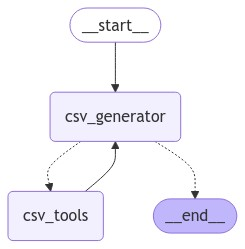

In [63]:
## Build graph
graph_builder = StateGraph(State)

## Initialize LLM with SQL tools
openai_llm = ChatOpenAI(model="gpt-4o-mini", api_key=os.environ["OPENAI_API_KEY"])
llm_with_csv_tools = openai_llm.bind_tools(csv_tools)

## Node for CSV tools
def csv_generator(state: State):
    return {"messages": [llm_with_csv_tools.invoke(state["messages"])]}

graph_builder.add_node("csv_generator", csv_generator)

csv_tool_node = ToolNode(tools=csv_tools)
graph_builder.add_node("csv_tools", csv_tool_node)

## If the message in csv_generator has tool calls, this edge routes it to the tools
csv_tools_condition = create_tools_condition("csv_tools")
graph_builder.add_conditional_edges("csv_generator", csv_tools_condition)

## Every time tool is called, return to generator to determine next step
graph_builder.add_edge("csv_tools", "csv_generator")
graph_builder.set_entry_point("csv_generator")
csv_graph = graph_builder.compile()
draw_graph(csv_graph)

In [64]:
csv_prompt = "Analyze the relationship between the 'Exchange' and 'Price' columns in the data."

pprint(stream_graph_updates(csv_graph, csv_prompt))

LLM: 
LLM: {'Exchange_summary': {'count': 5000, 'unique': 2, 'top': 'ASX', 'freq': 2529}, 'Price_summary': {'count': 5000.0, 'mean': 197.272703672342, 'std': 137.3328735146845, 'min': 28.73131515, '25%': 66.2565975975, '50%': 192.09030074999998, '75%': 314.656192925, 'max': 491.3966331}, 'relationship': {'type': 'categorical-continuous'}}
LLM: The analysis of the relationship between the 'Exchange' and 'Price' columns reveals the following insights:

### Exchange Column
- **Count**: 5000 entries
- **Unique Exchanges**: 2 (there are two different exchanges represented)
- **Top Exchange**: ASX (Australian Securities Exchange)
- **Frequency of Top Exchange**: 2529 occurrences (approximately 50.58% of the total entries)

### Price Column
- **Count**: 5000 entries
- **Mean Price**: 197.27
- **Standard Deviation**: 137.33 (indicates variability in prices)
- **Minimum Price**: 28.73
- **25th Percentile (Q1)**: 66.26
- **Median (Q2)**: 192.09
- **75th Percentile (Q3)**: 314.66
- **Maximum Pric

Try generating chart descriptions